## Example of rigid body dynamic: Pendulum 3D
Given Scalar Velocity $V_o = \mathring{P_o} $ and Acceleration $\alpha_o = \mathring{V_o} $ of the origin, Moment of Inertia matrix $M_{cg}$, and all forces $F_{cg}$ and $F_o$, find out the Equation of motion of the mass at the *CG* (center of gravity)

## Function section, run this section first

In [1]:
#function section 
using LinearAlgebra

function bracket(omega)
    return [0 -omega[3] omega[2]; omega[3] 0 -omega[1]; -omega[2] omega[1] 0]
end

function RotX(x) 
    Rx = [1 0 0;0 cos(x) -sin(x);0 sin(x) cos(x)]
    return Rx
end

function RotY(y) 
    Ry = [cos(y) 0 sin(y);0 1 0;-sin(y) 0 cos(y)]
    return Ry
end
function RotZ(z) 
    Rz = [cos(z) -sin(z) 0;sin(z) cos(z) 0;0 0 1]
    return Rz
end

function CardanR(x,y,z) #Euler method for rotating around x,y,z axis respectively to get the rotation matrix R
    Rx = [1 0 0;0 cos(x) -sin(x);0 sin(x) cos(x)]
    Ry = [cos(y) 0 sin(y);0 1 0;-sin(y) 0 cos(y)]
    Rz = [cos(z) -sin(z) 0;sin(z) cos(z) 0;0 0 1]
    return Rx*Ry*Rz
end

function Adjoint(twist)
    omega = twist[1:3]
    v = twist[4:6]
    zero = zeros((3,3))
    adj_matrix = [bracket(omega) zero;bracket(v) bracket(omega)]
    return adj_matrix
end

function ad(V)#(small_A small_d for twist V; lecture 15 page 11,also Featherstone section 2.9)
    omega = V[1:3]
    velo = V[4:6]
    zero = zeros((3,3))
    operator = [bracket(omega) zero;bracket(velo) bracket(omega)]    
    return operator
end

function ad_transpose(V) #(small_A small_d for twist V; lecture 15 page 11,also Featherstone section 2.9)
    omega = V[1:3]
    velo = V[4:6]
    zero = zeros((3,3))
    operator = -[bracket(omega) bracket(velo);zero bracket(omega)]   
        return operator
    end

function Transfer_Matrix_v(theta,p,ActiveDof) #Adjoint matrix for spatial vectors(big_A small_d)
    zero = zeros((3,3))
    ones = I(3)
    if ActiveDof == "x"
        E = inv(RotX(theta[1]))
    elseif ActiveDof == "y"
        E = inv(RotY(theta[2]))
    elseif ActiveDof == "z"  
        E = inv(RotZ(theta[3])) #or transpose(RotZ(theta[3])), since inv and transpose for transformation are equal
    end
    Rotmatrix = [E zero;zero E]
    Transmatrix = [ones zero; -bracket(p) ones]
    D = Transmatrix*Rotmatrix #rotation before translation because we the relative position between o and cg is known
    return D
end

function Transfer_Matrix_f(theta,p,ActiveDof) #adjoint matrix for spatial vectors
        zero = zeros((3,3))
    ones = I(3)
    if ActiveDof == "x"
        E = inv(RotX(theta[1]))
    elseif ActiveDof == "y"
        E = inv(RotY(theta[2]))
    elseif ActiveDof == "z"  
        E = inv(RotZ(theta[3]))
    end
    Rotmatrix = [E zero;zero E]
    Transmatrix = [ones -bracket(p); zero ones]
    D_star  = Transmatrix*Rotmatrix #rotation before translation because we the relative position between o and cg is known
    return D_star
end
function T(ActiveDof)
    T = I(6)
    if ActiveDof == "z"
        T[3,3] = 0  
    end
    return T
end
# function Transformation(M,*S)
#     for s = length(S)
#     exp(bracket(s))
#     end 
#     return 
# end
function Uactive_DOF(u,ActiveDof)
    if ActiveDof == "z"
       variable = [0;0;u[3];0;0;0;0;0;u[9];0;0;0;u[13];u[14];0;u[16];u[17];u[18]]
    end
        return variable 
end

function dUactive_DOF(du,ActiveDof)
    if ActiveDof == "z"
        du[1] = 0;du[2] = 0;du[4] = 0;du[5] = 0;du[6] = 0;du[7] = 0;du[8] = 0;du[10] = 0;du[11] = 0;du[12] = 0;du[15]=0
        return du
    end
end

function active_mass_matrx(ActiveDof)
    if ActiveDof == "z"
        return [0;0;1;0;0;0;0;0;1;0;0;0;0;0;0;0;0;0]
    end
end

active_mass_matrx (generic function with 1 method)

## Fourth try, using only the variables defined: works!!!!
Julia DAE solver example: https://diffeq.sciml.ai/stable/tutorials/dae_example/
<br>UIUC ECE 470 class material: https://publish.illinois.edu/belabbas/ece-470-fall-2020/
<br>FeatherStone "Rigid Body Dynamics Algorithms": https://link.springer.com/book/10.1007/978-1-4899-7560-7

**EOM** about CG: $F_{cg} = G_{cg} \dot{V_{cg}} -  ad_{V_{cg}}^T G_{cg} V_{cg}$,<br> where spatial matrix $G_{cg} = \begin{bmatrix}I_{cg} & 0 \\0 & m*I \end{bmatrix}$, and $G_{cg}^{-1} = \begin{bmatrix}I_{cg}^{-1} & 0 \\0 & I/m \end{bmatrix}$; $I_{cg} = \begin{bmatrix}I_{xx} & I_{xy}&I_{xz} \\I_{yx} & I_{yy}&I_{yz} \\I_{zx} & I_{zy}&I_{zz}\end{bmatrix}$, and $I$ is the $3\times3$ identity matrix.
<br>*Additionally*, adjoint matrix (lower case **ad()** ):
<br>$V_{cg}\times = ad_{V_{cg}} = \begin{bmatrix} [\omega_{cg}]&0 \\ [v_{cg}] & [\omega_{cg}] \end{bmatrix}; V_{cg}\times^* = -ad_{V_{cg}}^T = \begin{bmatrix} [\omega_{cg}]&[v_{cg}] \\ 0 & [\omega_{cg}] \end{bmatrix}$, $F_{cg} = \begin{bmatrix} m_{cg} \\ f_{cg} \end{bmatrix}$, and  $V_{cg} = \begin{bmatrix} \omega_{cg} \\ v_{cg} \end{bmatrix}$ (ECE 470 lec15)

<br><br> *Moreover*, Adjoint matrix (upper case **Ad()** ):
 <br>Transformation matrix for $V_o = ~^o\!D_{cg} V_{cg}$ **spatial variable**: $~^o\!D_{cg} = Ad_{T_{o,cg}} = \begin{bmatrix}~^o\!R_{cg} & 0 \\0 & ~^o\!R_{cg} \end{bmatrix} \begin{bmatrix} 1 & 0 \\-P\times & 1 \end{bmatrix} = \begin{bmatrix}~^o\!R_{cg} & 0 \\-~^o\!R_{cg}P\times & ~^o\!R_{cg} \end{bmatrix} $
            <br><br> Transformation matrix for $F_o = ~^o\!D_{cg}^* F_{cg}$ **force variable**: $~^o\!D_{cg}^* = Ad_{T_{o,cg}}^T = \begin{bmatrix}~^o\!R_{cg} & 0 \\0 & ~^o\!R_{cg} \end{bmatrix} \begin{bmatrix} 1 & -P\times \\0 & 1 \end{bmatrix} = \begin{bmatrix}~^o\!R_{cg} & -~^o\!R_{cg}P\times \\0 & ~^o\!R_{cg} \end{bmatrix} $<br> where $~^o\!R_{cg}$ is the rotational transformation from $cg$ to $o$. If $o$ is a fixed frame and frame $cg$ is rotating $\theta$ away from the frame $o$, then $~^{cg}\!R_{o} = Rot(axis,\theta) \Longrightarrow ~^{o}\!R_{cg} = inv(Rot(axis,\theta))=transpose(Rot(axis,\theta))$; $P$ is the vector $o \rightarrow cg$ measured in the $cg$ coordinate (ECE 470 lec 6 & Featherstone sec 2.8)         
<br>
Differentiation: $ ~^{cg}\!\dot{V}= ~^{cg}\!D_{o} ~^{o}\!\dot{V} = ~^{cg}\!D_{o}( ~^{o}\!\mathring{V} + ~^{i}\!V_{i}\times ~^{o}\!V)$ (Featherstone Sec 2.10 (P28); Details about $i$ frame see following section)<br>
### **Pendulum Example:** 
(Rotating around z axis) **Modified EOM** for the *spatial variable* and *force variable* applied on the origin. 
<br>**Frames** $o$: fixed origin frame; $i$: joint frame,located at origin (only rotating $\theta$ away from fixed $o$ frame, no translational displacement); $cg$: body frame at center of gravity (only translating $p$ away from $i$ frame); $j$: body frame,same orientation as $o$ but located at $cg$ (only translating $p$ away from $o$ frame).
<br> $F_{cg} = G_{cg} \dot{V_{cg}} -  ad_{V_{cg}}^T G_{cg} V_{cg} \Longrightarrow ~^{cg}\!D_{o}^* F_{o} + ~^{cg}\!D_{j}^* F_{g} = G_{cg} ~^{cg}\!D_{o}(\dot{V_{o}} + V_{i}\times V_{o}) + V_{cg}\times^* G_{cg}V_{cg} $ (might still have mistake)
where $V_{cg}=~^{cg}\!D_{o}V_{o}$

 **Finally, the equation becomes $\dot{V_{o}} = ~^{cg}\!D_{o}^{-1}G_{cg}^{-1}( ~^{cg}\!D_{o}^* F_{o} + ~^{cg}\!D_{j}^* F_{g} + V_{cg}\times^* G_{cg}V_{cg}) - V_{i}\times V_{o}$**
<br>Because we know that the pendulum can only rotate around $z$ axis, so the velocity vector in all other directions must equal to 0, that is $V_{o} = \begin{bmatrix} \omega_{o} \\ v_{o} \end{bmatrix} = \begin{bmatrix} 0 \\ 0\\ \omega_z \\0\\0\\0 \end{bmatrix}$. Accordingly,the the revolute joint around $z$ axis can provide reaction load for $\tau_x, \tau_y, F_x, F_y, F_z$ but gives $\tau_z = 0$. We will need to solve the system of equations using the DAE solver (1 differential equation for $\theta_z$ (or $\omega_z$) and 5 algebra equations for $\tau_x, \tau_y, F_x, F_y, F_z$)
<br><br>In the following example, the variables are $u_1 = \theta_z, u_2 = \omega_z, u_3 = \tau_x, u_4 = \tau_y, u_5 = F_x, u_6 = F_y, u_7 = F_z$.

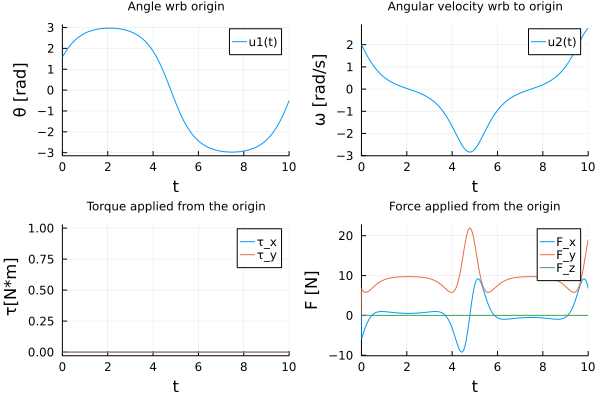

In [2]:
using DifferentialEquations
using LinearAlgebra
using Sundials
using Plots
g = 9.81
r_O_CG = [0; -1.5; 0]#initial center of mass wrb to joint (inertia frame)
r_end_CG = [0,1.5,0]#initial center of mass wrb to end of body (inertia frame)
m = 1 #mass of the body = rho*V
MOI = [5 0 0;0 5 0;0 0 5]
Inertia_mat = [MOI zeros(3,3);zeros(3,3) m*I(3)]
inv_inertia_mat = [inv(MOI) zeros(3,3);zeros(3,3) I(3)/m] #(book feathstone equ 2.73)
function fun(out,du,u,p,t)
    #u1 = theta_z, u2 = omega_z, u3 = moment_x , u4 = moment_y, u5 = Force_x, u6 = Force_y, u7 = Force_z all at the origin. 
#     Force = [0;0;0;0;-m*g;0]
#     u = Uactive_DOF(u,"z")
    GravityForce = Transfer_Matrix_f([0;0;u[1]],[0;0;0],"z")*[0;0;0;0;-m*g;0]
#     ReactionForce = -T("z")*inv(Transfer_Matrix_f(u[1:3],[0;-1.5;0],"z"))*GravityForce
    Force = GravityForce + Transfer_Matrix_f([0;0;u[1]],[0;0;0] + r_O_CG,"z")*[u[3];u[4];0;u[5];u[6];u[7]]#position change from [0;0;0] to [0;-1.5;0] 
    Matrixv = Transfer_Matrix_v([0;0;u[1]],[0;0;0]+r_O_CG,"z")#cg_D_J
    v_cg = Matrixv*[0;0;u[2];0;0;0]
    v_iframe = Transfer_Matrix_v([0;0;u[1]],[0;0;0],"z")*[0;0;u[2];0;0;0]
    accelmatrix = inv(Matrixv)*(inv_inertia_mat*(Force + ad_transpose(v_cg)*Inertia_mat*v_cg))-ad(v_iframe)*[0;0;u[2];0;0;0]
#     du[1:6] = dUactive_DOF(du,"z")
    out[1] = u[2]-du[1]
    out[2] = accelmatrix[3] - du[2]
    out[3] = accelmatrix[1]
    out[4] = accelmatrix[2]
    out[5] = accelmatrix[4]
    out[6] = accelmatrix[5]
    out[7] = accelmatrix[6]
end

ω_z0 = 2 #initial angular velocity around z
θ_z0 = pi/2 #initial angle around z

du0=[ω_z0; 0; 0; 0; 0; 0; 0]
u0=[θ_z0; ω_z0; 0; 0; 0; 0; 0]
tspan=(0.0,10)#time span
# f = ODEFunction(EOM3D!,mass_matrix = active_mass_matrx("z"))
# prob=ODEProblem(f,u0,tspan)
# sol=solve(prob,reltol=1e-8,Tsit5())
differential_vars = [true;true;false;false;false;false;false]
prob = DAEProblem(fun,du0,u0,tspan,differential_vars=differential_vars)
# sol = solve(prob,Rodas5(autodiff=false))
sol = solve(prob,IDA())
# plot(sol, tspan=(0.0,10), layout=(7,1))
# plot(sol)

a=plot(sol,vars=(0,[1]),title="Angle wrb origin",ylab = "θ [rad]",titlefontsize=8)
b=plot(sol,vars=(0,[2]),title="Angular velocity wrb to origin",ylab = "ω [rad/s]",titlefontsize=8)
c=plot(sol,vars=(0,[3,4]),title="Torque applied from the origin",labels=["τ_x" "τ_y" ],ylab = " τ[N*m]",titlefontsize=8)
d=plot(sol,vars=(0,[5,6,7]),title="Force applied from the origin",labels=["F_x" "F_y" "F_z"],ylab = "F [N]",titlefontsize=8)
# e=plot(sol,vars=(0,[13,14,15]),title="Position wrb to inertia frame",labels=["x_i" "y_i" "z_i"],ylab = "x_i [m]",titlefontsize=8)
# f=plot(sol,vars=(0,[16,17,18]),title="Velocity wrb to inertia frame",labels=["u_i" "v_i" "w_i"],ylab = "V_i [m/s]",titlefontsize=8)
plot(a,b,c,d,layout=(2,2))
# plot(plot(a,b,layout=(1,2),w=1),plot(c,d,layout=(1,2),w=1),layout=(2,1))

### Double Pendulum Example:
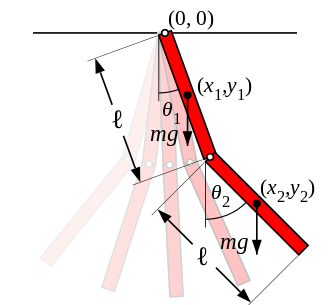

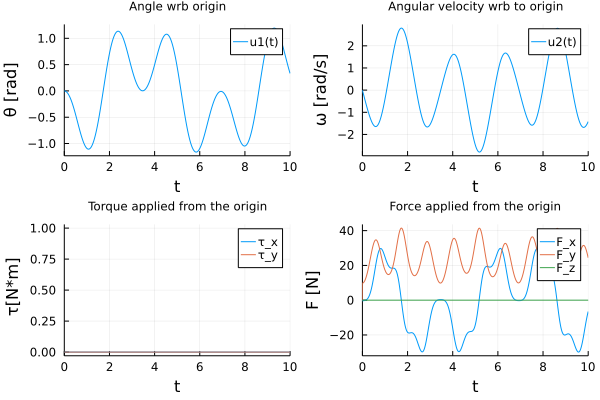

In [8]:
using DifferentialEquations
using LinearAlgebra
using Sundials
using Plots
g = 9.81
r_O1_CG1 = [0; -1.5; 0] #center of mass1 wrb to origin1(inertia frame)
r_O2_CG1 = [0; 1.5; 0] #center of mass1 wrb to origin1(inertia frame)
r_O2_CG2 = [0; -2.5; 0]#center of mass2 wrb to origin2(body frame)
m_1 = 1 #mass of the body 1 = rho*V
MOI_1 = [2 0 0;0 2 0;0 0 2]
m_2 = 2 #mass of the body 1 = rho*V
MOI_2 = [5 0 0;0 5 0;0 0 5]
Inertia_mat_1 = [MOI_1 zeros(3,3);zeros(3,3) m_1*I(3)]
inv_inertia_mat_1 = [inv(MOI_1) zeros(3,3);zeros(3,3) I(3)/m_1]
Inertia_mat_2 = [MOI_2 zeros(3,3);zeros(3,3) m_2*I(3)]
inv_inertia_mat_2 = [inv(MOI_2) zeros(3,3);zeros(3,3) I(3)/m_2]

function func(out,du,u,p,t)
    #u1 = theta_z, u2 = omega_z, u3 = moment_x , u4 = moment_y, u5 = Force_x, u6 = Force_y, u7 = Force_z all at the origin. 
    #u8 = theta_z_2, u9 = omega_z_2, u10 = moment_x_2 , u11 = moment_y_2, u12 = Force_x_2, u13 = Force_y_2, u14 = Force_z_2 all at the origin. 
    GravityForce_1 = Transfer_Matrix_f([0;0;u[1]],[0;0;0],"z")*[0;0;0;0;-m_1*g;0]
    GravityForce_2 = Transfer_Matrix_f([0;0;u[1]+u[8]],[0;0;0],"z")*[0;0;0;0;-m_2*g;0]
#     ReactionForce = -T("z")*inv(Transfer_Matrix_f(u[1:3],[0;-1.5;0],"z"))*GravityForce
    Force_1 = GravityForce_1 + Transfer_Matrix_f([0;0;u[1]],[0;0;0] + r_O1_CG1,"z")*[u[3];u[4];0;u[5];u[6];u[7]] + Transfer_Matrix_f([0;0;0],[0;0;0] + r_O2_CG1,"z")*(-1)*[u[10];u[11];0;u[12];u[13];u[14]] 
    Matrixv_1 = Transfer_Matrix_v([0;0;u[1]],[0;0;0]+r_O1_CG1,"z")#cg_D_J
    v_cg_1 = Matrixv_1*[0;0;u[2];0;0;0]
    v_iframe_1 = Transfer_Matrix_v([0;0;u[1]],[0;0;0],"z")*[0;0;u[2];0;0;0]
    accelmatrix_1 = inv(Matrixv_1)*(inv_inertia_mat_1*(Force_1 + ad_transpose(v_cg_1)*Inertia_mat_1*v_cg_1))-ad(v_iframe_1)*[0;0;u[2];0;0;0]
    Force_2 = GravityForce_2 + Transfer_Matrix_f([0;0;0],[0;0;0] + r_O2_CG2,"z")*[u[10];u[11];0;u[12];u[13];u[14]] 
    Matrixv_2 = Transfer_Matrix_v([0;0;u[8]],[0;0;0]+r_O2_CG2,"z")#cg_D_J
    v_cg_2 = Matrixv_2*[0;0;u[9];0;0;0]
    v_iframe_2 = Transfer_Matrix_v([0;0;u[8]],[0;0;0],"z")*[0;0;u[9];0;0;0]
    accelmatrix_2 = inv(Matrixv_2)*(inv_inertia_mat_2*(Force_2 + ad_transpose(v_cg_2)*Inertia_mat_2*v_cg_2))-ad(v_iframe_2)*[0;0;u[9];0;0;0]
    out[1] = u[2]-du[1]
    out[2] = accelmatrix_1[3] - du[2]
    out[3] = accelmatrix_1[1]
    out[4] = accelmatrix_1[2]
    out[5] = accelmatrix_1[4]
    out[6] = accelmatrix_1[5]
    out[7] = accelmatrix_1[6]
    
    out[8] = u[9]-du[8]
    out[9] = accelmatrix_2[3] - du[9]
    out[10] = accelmatrix_2[1]
    out[11] = accelmatrix_2[2]
    out[12] = accelmatrix_2[4]
    out[13] = accelmatrix_2[5]
    out[14] = accelmatrix_2[6]
end

ω_z1 = 0 #initial angular velocity around z
θ_z1 = 0 #initial angle around z
ω_z2 = 0 
θ_z2 = pi/2 
du0=[ω_z1; 0; 0; 0; 0; 0; 0;ω_z2; 0; 0; 0; 0; 0; 0]
u0=[θ_z1; ω_z1; 0; 0; 0; 0; 0;θ_z2; ω_z2; 0; 0; 0; 0; 0]
tspan=(0.0,10)#time span
# f = ODEFunction(EOM3D!,mass_matrix = active_mass_matrx("z"))
# prob=ODEProblem(f,u0,tspan)
# sol=solve(prob,reltol=1e-8,Tsit5())
differential_vars = [true;true;false;false;false;false;false;true;true;false;false;false;false;false]
prob = DAEProblem(func,du0,u0,tspan,differential_vars=differential_vars)
# sol = solve(prob,Rodas5(autodiff=false))
sol = solve(prob,IDA())
# plot(sol, tspan=(0.0,10), layout=(7,1))
# plot(sol)

a=plot(sol,vars=(0,[1]),title="Angle wrb origin",ylab = "θ [rad]",titlefontsize=8)
b=plot(sol,vars=(0,[2]),title="Angular velocity wrb to origin",ylab = "ω [rad/s]",titlefontsize=8)
c=plot(sol,vars=(0,[3,4]),title="Torque applied from the origin",labels=["τ_x" "τ_y" ],ylab = " τ[N*m]",titlefontsize=8)
d=plot(sol,vars=(0,[5,6,7]),title="Force applied from the origin",labels=["F_x" "F_y" "F_z"],ylab = "F [N]",titlefontsize=8)
# e=plot(sol,vars=(0,[13,14,15]),title="Position wrb to inertia frame",labels=["x_i" "y_i" "z_i"],ylab = "x_i [m]",titlefontsize=8)
# f=plot(sol,vars=(0,[16,17,18]),title="Velocity wrb to inertia frame",labels=["u_i" "v_i" "w_i"],ylab = "V_i [m/s]",titlefontsize=8)
plot(a,b,c,d,layout=(2,2))
# plot(plot(a,b,layout=(1,2),w=1),plot(c,d,layout=(1,2),w=1),layout=(2,1))

In [ ]:
#test, not use
function aaa(du)
# du = zeros(1,12)
    du[1:2 4:8 10:12] = [1;1;1;1;1;1;1;1;1;1]
return du
end 
aaa(zeros(1,12))

In [ ]:
#test, not use
exp([1 1 1;2 2 2;3 3 3])
Transfer_Matrix_v([1 2 3],[1 2 3],"x")
m=1 #mass of the body = rho*V
MOI=[1 0 0;0 1 0;0 0 1]
Inertia_mat = [MOI zeros(3,3);zeros(3,3) m*I(3)]
inv_inertia_mat = [inv(MOI) zeros(3,3);zeros(3,3) I(3)/m]
ad([1;1;1;1;1;1])
# inv(Inertia_mat)
Force = Transfer_Matrix_f([0;0;pi/2],[0;0;0],"z")*[0;0;0;0;-9.8;0]
Matrixv = Transfer_Matrix_v([0;0;pi/2],[0;-1.5;0],"z")
v_cg = Matrixv*[0;0;0;0;0;0]
inv(Matrixv)*inv_inertia_mat*Force
inv(Matrixv)*[0;0;0;-1;0;0]
inv(Matrixv)*[0;0;pi/2;pi/2*1.5;0;0]
inv(Transfer_Matrix_f([0;0;pi/2],[0;-1.5;0],"z"))*Force
Matrixv*[0;0;pi/2;0;0;0]
Force

In [ ]:
using DifferentialEquations
using LinearAlgebra
using Plots
g = 9.81
M = [2;1.5; 3] # Moment applied on the joint
F = [2.5; 3; 2] # Force applied on the body end
r_O_CG = [0; -1.5; 0]#initial center of mass wrb to joint (inertia frame)
r_end_CG = [0,1.5,0]#initial center of mass wrb to end of body (inertia frame)
m=1 #mass of the body = rho*V
MOI=[5 0 0;0 5 0;0 0 5]
Inertia_mat = [MOI zeros(3,3);zeros(3,3) m*I(3)]
inv_inertia_mat = [inv(MOI) zeros(3,3);zeros(3,3) I(3)/m] #(book equ 2.73)
function EOM3D!(du,u,p,t)
    #u7 = omega1, u8 = omega2, u9 = omega3 , u10 = u, u11 = v, u12 = w; 
#     Force = [0;0;0;0;-m*g;0]
    GravityForce = Transfer_Matrix_f(u[1:3],[0;0;0],"z")*[0;0;0;0;-m*g;0]
    ReactionForce = -T("z")*inv(Transfer_Matrix_f(u[1:3],[0;-1.5;0],"z"))*GravityForce
    Force = GravityForce + Transfer_Matrix_f(u[1:3],[0;-1.5;0],"z")*ReactionForce#position change from [0;0;0] to [0;-1.5;0] 
    Matrixv = Transfer_Matrix_v(u[1:3],u[4:6]+r_O_CG,"z")#cg_D_J
    v_cg = Matrixv*u[7:12]
    du[7:12] = inv(Matrixv)*(inv_inertia_mat*(Force + ad_transpose(v_cg)*Inertia_mat*v_cg))-ad(v_cg)*u[7:12]
    du[1:6] = u[7:12]
end

u0=[0; 0; pi/2; 0; 0; 0; 0; 0; 0; 0; 0; 0]
tspan=(0.0,10)#time span
prob=ODEProblem(EOM3D!,u0,tspan)
sol=solve(prob,reltol=1e-8,Tsit5())

a=plot(sol,vars=(0,[10,11,12]),title="Velocity of cg wrb origin",labels=["u_b" "v_b" "w_b"],ylab = "V_b [m/s]",titlefontsize=8)
b=plot(sol,vars=(0,[7,8,9]),title="Angular velocity of cg  wrb to origin",labels=["ω1" "ω2" "ω3"],ylab = "ω_b [rad/s]",titlefontsize=8)
c=plot(sol,vars=(0,[4,5,6]),title="Position of cg wrb to origin",ylab = "x_b [m]",titlefontsize=8)
d=plot(sol,vars=(0,[1,2,3]),title="Angle of cg wrb origin",labels=["ϕ" "Θ" "Ψ"],ylab = "θ [rad]",titlefontsize=8)
# e=plot(sol,vars=(0,[13,14,15]),title="Position wrb to inertia frame",labels=["x_i" "y_i" "z_i"],ylab = "x_i [m]",titlefontsize=8)
# f=plot(sol,vars=(0,[16,17,18]),title="Velocity wrb to inertia frame",labels=["u_i" "v_i" "w_i"],ylab = "V_i [m/s]",titlefontsize=8)
# plot(a,b,d,f,layout=(2,2))
plot(plot(a,b,layout=(1,2),w=1),plot(c,d,layout=(1,2),w=1),layout=(2,1))

## Second try: Using origin(reference) as variables: not work

In [ ]:
using DifferentialEquations
using LinearAlgebra
using Plots
g = 9.81
r_O_CG = [0; -1.5; 0]#initial center of mass wrb to joint (inertia frame)
r_end_CG = [0,1.5,0]#initial center of mass wrb to end of body (inertia frame)
m=1 #mass of the body = rho*V
MOI=[5 0 0;0 5 0;0 0 5]
Inertia_mat = [MOI zeros(3,3);zeros(3,3) m*I(3)]
inv_inertia_mat = [inv(MOI) zeros(3,3);zeros(3,3) I(3)/m] #(book equ 2.73)
function EOM3D!(out,du,u,p,t)
    #u7 = omega1, u8 = omega2, u9 = omega3 , u10 = u, u11 = v, u12 = w; 
#     Force = [0;0;0;0;-m*g;0]
    u = Uactive_DOF(u,"z")
    GravityForce = Transfer_Matrix_f(u[1:3],[0;0;0],"z")*[0;0;0;0;-m*g;0]
#     ReactionForce = -T("z")*inv(Transfer_Matrix_f(u[1:3],[0;-1.5;0],"z"))*GravityForce
    Force = GravityForce + Transfer_Matrix_f(u[1:3],[0;-1.5;0],"z")*u[13:18]#position change from [0;0;0] to [0;-1.5;0] 
    Matrixv = Transfer_Matrix_v(u[1:3],u[4:6]+r_O_CG,"z")#cg_D_J
    v_cg = Matrixv*u[7:12]
    du[13,14,9,16,17,18] = inv(Matrixv)*(inv_inertia_mat*(Force + ad_transpose(v_cg)*Inertia_mat*v_cg))-ad(v_cg)*u[7:12]
    du = dUactive_DOF(du,"z")
    nothing
end

u0=[0; 0; pi/2; 0; 0; 0; 0; 0; 0; 0; 0; 0;0;0;0;0;0;0]
tspan=(0.0,10)#time span
f = ODEFunction(EOM3D!,mass_matrix = active_mass_matrx("z"))
prob=ODEProblem(f,u0,tspan)
sol=solve(prob,reltol=1e-8,Tsit5())

a=plot(sol,vars=(0,[10,11,12]),title="Velocity of cg wrb origin",labels=["u_b" "v_b" "w_b"],ylab = "V_b [m/s]",titlefontsize=8)
b=plot(sol,vars=(0,[7,8,9]),title="Angular velocity of cg  wrb to origin",labels=["ω1" "ω2" "ω3"],ylab = "ω_b [rad/s]",titlefontsize=8)
c=plot(sol,vars=(0,[4,5,6]),title="Position of cg wrb to origin",ylab = "x_b [m]",titlefontsize=8)
d=plot(sol,vars=(0,[1,2,3]),title="Angle of cg wrb origin",labels=["ϕ" "Θ" "Ψ"],ylab = "θ [rad]",titlefontsize=8)
# e=plot(sol,vars=(0,[13,14,15]),title="Position wrb to inertia frame",labels=["x_i" "y_i" "z_i"],ylab = "x_i [m]",titlefontsize=8)
# f=plot(sol,vars=(0,[16,17,18]),title="Velocity wrb to inertia frame",labels=["u_i" "v_i" "w_i"],ylab = "V_i [m/s]",titlefontsize=8)
# plot(a,b,d,f,layout=(2,2))
plot(plot(a,b,layout=(1,2),w=1),plot(c,d,layout=(1,2),w=1),layout=(2,1))

## Third trial: using OUT[1], OUT[2], OUT[3]: not work

In [ ]:
using DifferentialEquations
using LinearAlgebra
using Sundials
using Plots
g = 9.81
r_O_CG = [0; -1.5; 0]#initial center of mass wrb to joint (inertia frame)
r_end_CG = [0,1.5,0]#initial center of mass wrb to end of body (inertia frame)
m=1 #mass of the body = rho*V
MOI=[5 0 0;0 5 0;0 0 5]
Inertia_mat = [MOI zeros(3,3);zeros(3,3) m*I(3)]
inv_inertia_mat = [inv(MOI) zeros(3,3);zeros(3,3) I(3)/m] #(book equ 2.73)
function ff(out,du,u,p,t)
    #u7 = omega1, u8 = omega2, u9 = omega3 , u10 = u, u11 = v, u12 = w; 
#     Force = [0;0;0;0;-m*g;0]
#     u = Uactive_DOF(u,"z")
    GravityForce = Transfer_Matrix_f(u[1:3],[0;0;0],"z")*[0;0;0;0;-m*g;0]
#     ReactionForce = -T("z")*inv(Transfer_Matrix_f(u[1:3],[0;-1.5;0],"z"))*GravityForce
    Force = GravityForce + Transfer_Matrix_f(u[1:3],[0;-1.5;0],"z")*u[13:18]#position change from [0;0;0] to [0;-1.5;0] 
    Matrixv = Transfer_Matrix_v(u[1:3],u[4:6]+r_O_CG,"z")#cg_D_J
    v_cg = Matrixv*u[7:12]
    accelmatrix = inv(Matrixv)*(inv_inertia_mat*(Force + ad_transpose(v_cg)*Inertia_mat*v_cg))-ad(v_cg)*u[7:12]
#     du[1:6] = dUactive_DOF(du,"z")
    out[1] = 0
    out[2] = 0
    out[3] = u[9]-du[3]
    out[4] = 0
    out[5] = 0
    out[6] = 0
    out[7] = 0
    out[8] = 0
    out[9] = accelmatrix[3] - du[9]
    out[10] = 0
    out[11] = 0
    out[12] = 0
    out[13] = accelmatrix[1]
    out[14] = accelmatrix[2]
    out[15] = 0
    out[16] = accelmatrix[4]
    out[17] = accelmatrix[5]
    out[18] = accelmatrix[6]
    
end

du0=[0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0;0;0;0;0;0;0]
u0=[0; 0; pi/2; 0; 0; 0; 0; 0; 0; 0; 0; 0;0;0;0;0;0;0]
tspan=(0.0,10)#time span
# f = ODEFunction(EOM3D!,mass_matrix = active_mass_matrx("z"))
# prob=ODEProblem(f,u0,tspan)
# sol=solve(prob,reltol=1e-8,Tsit5())
differential_vars = [false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false]
prob = DAEProblem(ff,du0,u0,tspan,differential_vars=differential_vars)

sol = solve(prob,IDA())
# plot(sol)

a=plot(sol,vars=(0,[10,11,12]),title="Velocity of cg wrb origin",labels=["u_b" "v_b" "w_b"],ylab = "V_b [m/s]",titlefontsize=8)
b=plot(sol,vars=(0,[7,8,9]),title="Angular velocity of cg  wrb to origin",labels=["ω1" "ω2" "ω3"],ylab = "ω_b [rad/s]",titlefontsize=8)
c=plot(sol,vars=(0,[4,5,6]),title="Position of cg wrb to origin",ylab = "x_b [m]",titlefontsize=8)
d=plot(sol,vars=(0,[1,2,3]),title="Angle of cg wrb origin",labels=["ϕ" "Θ" "Ψ"],ylab = "θ [rad]",titlefontsize=8)
e=plot(sol,vars=(0,[13,14,15]),title="Position wrb to inertia frame",labels=["x_i" "y_i" "z_i"],ylab = "x_i [m]",titlefontsize=8)
f=plot(sol,vars=(0,[16,17,18]),title="Velocity wrb to inertia frame",labels=["u_i" "v_i" "w_i"],ylab = "V_i [m/s]",titlefontsize=8)
plot(a,b,d,f,layout=(2,2))
plot(plot(a,b,layout=(1,2),w=1),plot(c,d,layout=(1,2),w=1),layout=(2,1))
#not working

In [ ]:
Transfer_Matrix_f([0;0;pi/4],[0;0;0],"z")*[0;0;0;0;-m*g;0]
Transfer_Matrix_f([0;0;pi/4],[0;0;0]+r_O_CG,"z")*[0;0;0;0;1;0]
v_iframe = Transfer_Matrix_v([0;0;pi/4],[0;0;0],"z")*[0;0;1;0;0;0]
y = pi/6;mat=[cos(y) 0 sin(y);0 1 0;-sin(y) 0 cos(y)]
inv(mat),transpose(mat)

In [ ]:
import Pkg
Pkg.add("Sundials")

In [ ]:
using ModelingToolkit

@parameters t σ ρ β
@variables x(t) y(t) z(t)
@derivatives D'~t

eqs = [D(x) ~ σ*(y-x),
       D(y) ~ x*(ρ-z)-y,
       D(z) ~ x*y - β*z]
sys = ODESystem(eqs)

u0 = [x => 1.0
      y => 0.0
      z => 0.0]

p  = [σ => 10.0
      ρ => 28.0
      β => 8/3]
tspan = (0.0,100.0)
prob = ODEProblem(sys,u0,tspan,p;jac=true,sparse=true)